In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torch torchvision timm numpy pandas matplotlib opencv-python albumentations

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
DATA_PATH = "/content/drive/MyDrive/LungCancer"
CATEGORIES = ["lung_aca", "lung_n", "lung_scc"]
IMG_SIZE = 224


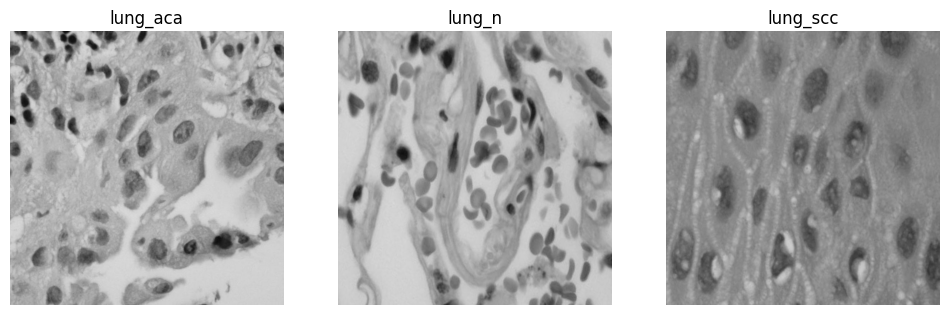

In [28]:
import matplotlib.pyplot as plt
import cv2
import random

# Function to get one random image from each class
def get_sample_images(root_dir, categories):
    images = []
    labels = []
    for category in categories:
        path = os.path.join(root_dir, category)
        img_name = random.choice(os.listdir(path))
        img_path = os.path.join(path, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        images.append(image)
        labels.append(category)
    return images, labels

# Get sample images
sample_images, sample_labels = get_sample_images(DATA_PATH, CATEGORIES)

# Plot images side by side
plt.figure(figsize=(12, 4))
for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()


In [6]:
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

valid_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
class LungCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        for category in CATEGORIES:
            path = os.path.join(root_dir, category)
            label = CATEGORIES.index(category)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                self.data.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label


In [8]:
dataset = LungCancerDataset(DATA_PATH, transform=train_transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.transform = train_transform
val_dataset.transform = valid_transform
test_dataset.transform = valid_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Train Size: {train_size}, Validation Size: {val_size}, Test Size: {test_size}")


Train Size: 10500, Validation Size: 2250, Test Size: 2250


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("coatnet_0_rw_224.sw_in1k", pretrained=True, num_classes=len(CATEGORIES))
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


In [12]:
num_epochs = 25
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/25 -> Train Loss: 0.2481, Train Acc: 90.42%, Val Loss: 0.0784, Val Acc: 96.49%
Epoch 2/25 -> Train Loss: 0.0948, Train Acc: 96.61%, Val Loss: 0.0746, Val Acc: 97.24%
Epoch 3/25 -> Train Loss: 0.0807, Train Acc: 97.22%, Val Loss: 0.0181, Val Acc: 99.60%
Epoch 4/25 -> Train Loss: 0.0452, Train Acc: 98.41%, Val Loss: 0.0425, Val Acc: 98.40%
Epoch 5/25 -> Train Loss: 0.0319, Train Acc: 98.84%, Val Loss: 0.0400, Val Acc: 98.49%
Epoch 6/25 -> Train Loss: 0.0148, Train Acc: 99.52%, Val Loss: 0.0188, Val Acc: 99.29%
Epoch 7/25 -> Train Loss: 0.0080, Train Acc: 99.72%, Val Loss: 0.0056, Val Acc: 99.82%
Epoch 8/25 -> Train Loss: 0.0043, Train Acc: 99.85%, Val Loss: 0.0015, Val Acc: 99.96%
Epoch 9/25 -> Train Loss: 0.0010, Train Acc: 99.97%, Val Loss: 0.0019, Val Acc: 99.96%
Epoch 10/25 -> Train Loss: 0.0019, Train Acc: 99.94%, Val Loss: 0.0013, Val Acc: 99.96%
Epoch 11/25 -> Train Loss: 0.0002, Train Acc: 100.00%, Val Loss: 0.0011, Val Acc: 99.96%
Epoch 12/25 -> Train Loss: 0.0007, Train

In [13]:
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 99.60%


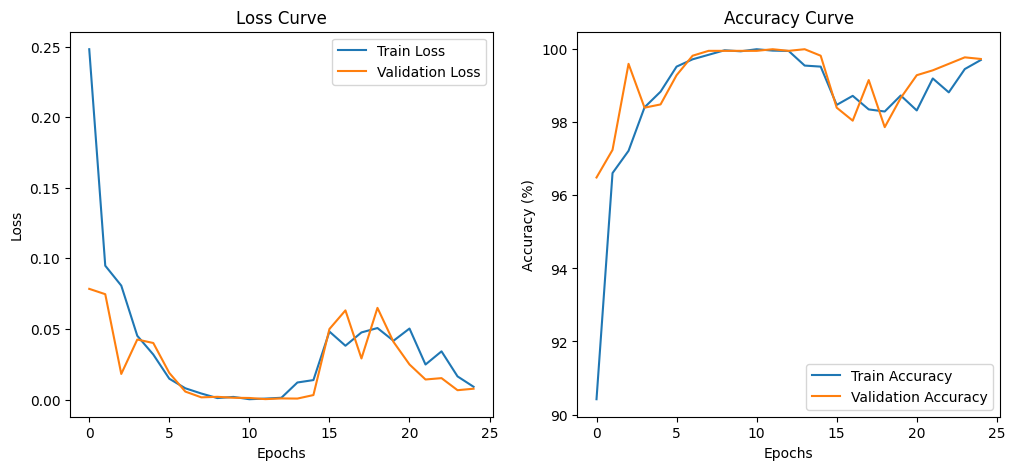

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


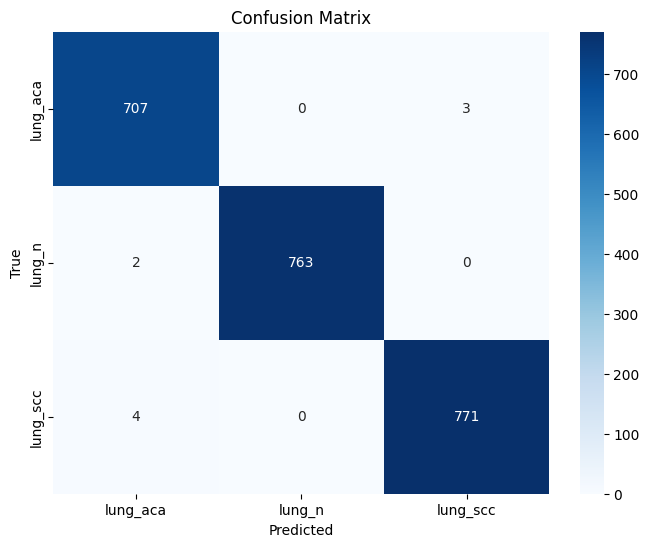

In [18]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CATEGORIES, yticklabels=CATEGORIES) # Use CATEGORIES for labels
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CATEGORIES))


              precision    recall  f1-score   support

    lung_aca       0.99      1.00      0.99       710
      lung_n       1.00      1.00      1.00       765
    lung_scc       1.00      0.99      1.00       775

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



In [20]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen Kappa Score: {kappa:.4f}")
print(f"Overall Accuracy: {test_accuracy:.2f}%")


Cohen Kappa Score: 0.9940
Overall Accuracy: 99.60%


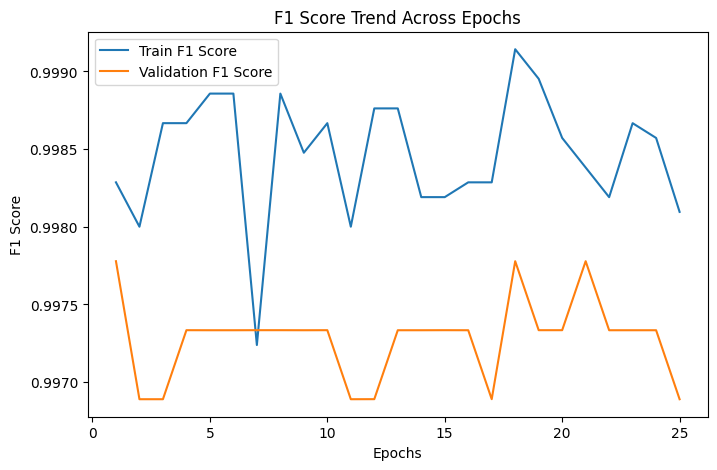

In [31]:
from sklearn.metrics import f1_score

train_f1_scores, val_f1_scores = [], []

for epoch in range(num_epochs):
    y_train_true, y_train_pred = [], []
    y_val_true, y_val_pred = [], []

    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_train_true.extend(labels.cpu().numpy())
        y_train_pred.extend(preds.cpu().numpy())

    train_f1 = f1_score(y_train_true, y_train_pred, average="weighted")
    train_f1_scores.append(train_f1)

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(preds.cpu().numpy())

    val_f1 = f1_score(y_val_true, y_val_pred, average="weighted")
    val_f1_scores.append(val_f1)

# Plot the F1 Score trend
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_f1_scores, label="Train F1 Score")
plt.plot(range(1, num_epochs + 1), val_f1_scores, label="Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score Trend Across Epochs")
plt.legend()
plt.show()
